In [ ]:
# === Library Dasar Python ===
import os
import pickle
from collections import Counter

# === Library untuk Analisis dan Visualisasi Data ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Library untuk Machine Learning & Preprocessing ===
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.tree import plot_tree, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.metrics import (
    root_mean_squared_error, mean_absolute_percentage_error, r2_score,
    accuracy_score, balanced_accuracy_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

# === Library untuk Model Tambahan ===
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVR, SVC

# === Library untuk Hyperparameter Tuning ===
import optuna

# === Library untuk Interpretasi Model ===
import shap

# === Library untuk Penanganan Data Imbalanced ===
from imblearn.over_sampling import SMOTE

# === Library untuk Dataset Eksternal ===
from datasets import load_dataset

# === Library Tambahan untuk Visualisasi Pohon ===
import graphviz

# === Supresi Warning ===
import warnings

from OLOS.OLOS import optimasiIndeksGabungan

/home/anugerahsurya/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Fungsi Visualisasi Data

In [ ]:
def visualisasiData(df):
    """
    Memvisualisasikan semua kolom numerik dan kategorik dalam sebuah DataFrame.

    Untuk setiap kolom numerik:
    - Histogram + KDE (sebaran)
    - Box plot (untuk deteksi outlier)

    Untuk setiap kolom kategorik:
    - Bar chart (frekuensi masing-masing kategori)

    Parameter:
    df (pd.DataFrame): DataFrame yang ingin divisualisasikan.
    """
    numeric_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category','bool']).columns

    # Visualisasi kolom numerik
    if len(numeric_cols) > 0:
        print(f"Memvisualisasikan {len(numeric_cols)} kolom numerik...")
        for col in numeric_cols:
            plt.figure(figsize=(12, 5))

            # Histogram
            plt.subplot(1, 2, 1)
            sns.histplot(df[col], kde=True, color='skyblue')
            plt.title(f'Histogram dari {col}')
            plt.xlabel(col)
            plt.ylabel('Frekuensi')

            # Box plot
            plt.subplot(1, 2, 2)
            sns.boxplot(y=df[col], color='lightcoral')
            plt.title(f'Box Plot dari {col}')
            plt.ylabel(col)

            plt.tight_layout()
            plt.show()
    else:
        print("Tidak ada kolom numerik dalam DataFrame ini.")

    # Visualisasi kolom kategorik
    if len(categorical_cols) > 0:
        print(f"Memvisualisasikan {len(categorical_cols)} kolom kategorik...")
        for col in categorical_cols:
            plt.figure(figsize=(8, 5))
            sns.countplot(data=df, x=col, palette='pastel', order=df[col].value_counts().index)
            plt.title(f'Bar Chart dari {col}')
            plt.xlabel(col)
            plt.ylabel('Frekuensi')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    else:
        print("Tidak ada kolom kategorik dalam DataFrame ini.")

# data = "Dataframe"
# visualisasiData(data)

## Analisis Korelasi dan Pengecekan Multikolinearitas

In [10]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def korelasiVIFTarget(df, target):
    """
    Menghitung korelasi Pearson terhadap kolom target dan VIF antar fitur numerik.

    Parameter:
        df (pd.DataFrame): DataFrame input.
        target (str): Nama kolom target.

    Return:
        pd.DataFrame: DataFrame berisi kolom:
            - 'Fitur': nama kolom fitur,
            - 'Korelasi': korelasi terhadap target,
            - 'VIF': nilai Variance Inflation Factor.
    """
    if target not in df.columns:
        raise ValueError(f"DataFrame tidak memiliki kolom target '{target}'.")

    # Pilih fitur numerik tanpa kolom target
    numeric_features = df.select_dtypes(include='number').drop(columns=[target])

    # Hitung korelasi Pearson terhadap target
    korelasi = df[numeric_features.columns].corrwith(df[target])

    # Hitung VIF
    X = add_constant(numeric_features)
    vif_values = [variance_inflation_factor(X.values, i + 1) for i in range(len(numeric_features.columns))]

    # Gabungkan ke dalam satu DataFrame
    result_df = pd.DataFrame({
        'Fitur': numeric_features.columns,
        'Korelasi': korelasi.values,
        'VIF': vif_values
    })

    # Urutkan berdasarkan nilai absolut korelasi
    result_df = result_df.reindex(result_df['Korelasi'].abs().sort_values(ascending=False).index)

    return result_df.reset_index(drop=True)

# data = "DataFrame"
# target = "Variabel Target"
# output = korelasiVIFTarget(data,target)

## Fungsi Eliminasi Outlier

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def EliminasiOutlier(X_train, y_train, contamination=0.05, case=1):
    # Fungsi untuk mendeteksi outlier menggunakan Isolation Forest
    def detect_outliers_isolation_forest(X, contamination):
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        outliers = iso_forest.fit_predict(X)
        df = pd.DataFrame(X, columns=X.columns)
        df['Outlier'] = outliers == -1
        return df

    # Fungsi untuk mengeliminasi outlier dari dataset
    def eliminate_outliers(df):
        cleaned_df = df[~df['Outlier']].drop(columns=['Outlier'])
        return cleaned_df

    # Standardisasi fitur X
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    if case == 1:
        # CASE 1: Deteksi outlier secara keseluruhan
        outlier_df = detect_outliers_isolation_forest(X_scaled, contamination)
        outlier_df[y_train.name] = y_train.values
        cleaned_data_scaled = eliminate_outliers(outlier_df)

    elif case == 2:
        # CASE 2: Deteksi outlier per kelas
        cleaned_parts = []

        for class_label in y_train.unique():
            class_mask = y_train == class_label
            X_class = X_scaled[class_mask]
            y_class = y_train[class_mask].reset_index(drop=True)

            outlier_df = detect_outliers_isolation_forest(X_class, contamination)
            outlier_df[y_train.name] = y_class
            cleaned_class_data = eliminate_outliers(outlier_df)
            cleaned_parts.append(cleaned_class_data)

        # Gabungkan kembali semua kelas yang telah dibersihkan
        cleaned_data_scaled = pd.concat(cleaned_parts, ignore_index=True)
    else:
        raise ValueError("Parameter 'case' hanya bisa bernilai 1 (umum) atau 2 (klasifikasi per kelas).")

    # Kembalikan data ke skala asli
    cleaned_X = scaler.inverse_transform(cleaned_data_scaled.drop(columns=[y_train.name]))
    cleaned_X = pd.DataFrame(cleaned_X, columns=X_train.columns)
    cleaned_y = cleaned_data_scaled[y_train.name].reset_index(drop=True)

    # Output info
    print(f"Jumlah data sebelum eliminasi outlier: {len(X_train)}")
    print(f"Jumlah data setelah eliminasi outlier: {len(cleaned_X)}")

    return cleaned_X, cleaned_y

## Fungsi Eksplorasi Best Fitur

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (root_mean_squared_error, f1_score)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from tqdm import tqdm
from itertools import combinations

def eksplorasiBestFitur(fixed_features, target, data, case=1):
    """
    Menguji semua kombinasi fitur tambahan dengan fixed features untuk regresi atau klasifikasi.

    Parameters:
    - fixed_features (list): Fitur yang selalu digunakan.
    - available_features (list): Fitur tambahan yang akan dikombinasikan.
    - target (str): Nama kolom target.
    - df (pd.DataFrame): Dataset utama.
    - case (int): 1 untuk regresi (RMSE), 2 untuk klasifikasi (F1 macro).

    Returns:
    - pd.DataFrame: Hasil kombinasi fitur, skor metrik terbaik, dan model terbaik.
    """
    results = []
    # Fitur tambahan
    available_features = [col for col in data.columns if col != target and col not in fixed_features]
    
    for i in tqdm(range(1, len(available_features) + 1), desc="Menguji kombinasi fitur tambahan"):
        for combo in combinations(available_features, i):
            features = fixed_features + list(combo)

            X = data[features]
            y = data[target]

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

            if case == 1:  # Regresi
                models = {
                    'KNN': KNeighborsRegressor(),
                    'CatBoost': CatBoostRegressor(verbose=0, random_state=1),
                    'RandomForest': RandomForestRegressor(random_state=1),
                    'SVR': SVR(),
                    'LightGBM': LGBMRegressor(random_state=1, verbose=-1)
                }
                metrics = {}
                for name, model in models.items():
                    model.fit(X_train, y_train)
                    preds = model.predict(X_test)
                    metrics[name] = root_mean_squared_error(y_test, preds)

                best_model = min(metrics, key=metrics.get)
                best_score = round(metrics[best_model], 4)

            elif case == 2:  # Klasifikasi
                models = {
                    'KNN': KNeighborsClassifier(),
                    'CatBoost': CatBoostClassifier(verbose=0, random_state=1),
                    'RandomForest': RandomForestClassifier(random_state=1),
                    'SVC': SVC(),
                    'LightGBM': LGBMClassifier(random_state=1, verbose=-1)
                }
                metrics = {}
                for name, model in models.items():
                    model.fit(X_train, y_train)
                    preds = model.predict(X_test)
                    metrics[name] = f1_score(y_test, preds, average='macro')

                best_model = max(metrics, key=metrics.get)
                best_score = round(metrics[best_model], 4)

            else:
                raise ValueError("Case harus bernilai 1 (regresi) atau 2 (klasifikasi).")

            results.append({
                'features': features,
                'score': best_score,
                'best_model': best_model
            })

    hasil_df = pd.DataFrame(results)
    hasil_df = hasil_df.sort_values(by='score', ascending=(case == 1)).reset_index(drop=True)
    return hasil_df

In [13]:
def preprocessingData(df, kolom, jenis=1, save_dir="Encoder Tersimpan", ordinal_order=None):
    os.makedirs(save_dir, exist_ok=True)
    encoder_path = os.path.join(save_dir, f"{kolom}_encoder.pkl")

    if jenis == 1:  # Label Encoding
        le = LabelEncoder()
        df[kolom] = le.fit_transform(df[kolom])
        with open(encoder_path, 'wb') as file:
            pickle.dump(le, file)
        return df, le

    elif jenis == 2:  # One Hot Encoding
        # One Hot Encoding tidak memerlukan encoder saat "use"
        df = pd.get_dummies(df, columns=[kolom], prefix=kolom)
        return df, None

    elif jenis == 3:  # Ordinal Encoding
        if ordinal_order is None:
            raise ValueError(f"Untuk kolom '{kolom}', 'ordinal_order' harus disediakan untuk Ordinal Encoding.")

        df[kolom] = df[kolom].astype(str)
        oe = OrdinalEncoder(categories=[ordinal_order])
        df[kolom] = oe.fit_transform(df[[kolom]])
        with open(encoder_path, 'wb') as file:
            pickle.dump(oe, file)
            
        return df, oe
    else:
        raise ValueError("Jenis encoding tidak valid: gunakan 1 (Label), 2 (One Hot), atau 3 (Ordinal)")

In [14]:
data = pd.read_csv("Data/used_car_price_dataset_extended.csv").dropna()
data = data.drop(columns=['color','brand'])
data.head()

,make_year,mileage_kmpl,engine_cc,fuel_type,owner_count,price_usd,transmission,service_history,accidents_reported,insurance_valid
2,2023,18.09,2500,Diesel,5,9273.58,Automatic,Full,1,Yes
3,2009,11.28,800,Petrol,1,6836.24,Manual,Full,0,Yes
4,2005,12.23,1000,Petrol,2,4625.79,Automatic,Full,0,Yes
5,2002,13.77,2500,Diesel,4,6856.03,Manual,Full,1,Yes
6,2023,12.50,1000,Petrol,3,6806.77,Manual,Full,0,Yes


In [ ]:
# ===================== Label Encoder =========================
df, encoder_fuel = preprocessingData(data, 'transmission', jenis=1, save_dir='Encoder')
df, encoder_sh = preprocessingData(df, 'service_history', jenis=1, save_dir='Encoder')
df, encoder_ar = preprocessingData(df, 'accidents_reported', jenis=1, save_dir='Encoder')
df, encoder_iv = preprocessingData(df, 'insurance_valid', jenis=1, save_dir='Encoder')

# ===================== One Hot Encoder ============================
df, encoder_brand = preprocessingData(df, 'brand', jenis=2, save_dir='Encoder')
df, encoder_color = preprocessingData(df, 'color', jenis=2, save_dir='Encoder')


# Hanya contoh
urutan_fuel = ['Diesel','Petrol','Electric']
# ===================== Ordinal Encoder ==========================
df, encoder_fuel = preprocessingData(df, 'fuel_type', jenis=3, ordinal_order=urutan_fuel, save_dir='Encoder')


In [16]:
target = 'price_usd'
dataset = korelasiVIFTarget(df, target)
dataset.head()

,Fitur,Korelasi,VIF
0,engine_cc,0.682698,1.001249
1,make_year,0.434953,1.001126
2,owner_count,-0.265805,1.001227
3,fuel_type,0.209511,1.000238
4,mileage_kmpl,0.205376,1.000522


In [ ]:
target = 'price_usd'
y = data[target]
X = df.drop(columns=target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# case 1: deteksi global
X_train, y_train = EliminasiOutlier(X_train.copy(), y_train.copy(), contamination=0.05, case=1)

# case 2: deteksi berdasarkan label kelas (klasifikasi)
#X_bersih, y_bersih = Eliminasi_Outlier(X_train.copy(), y_train.copy(), contamination=0.05, case=2)

Jumlah data sebelum eliminasi outlier: 6369
Jumlah data setelah eliminasi outlier: 6050


Memvisualisasikan 10 kolom numerik...


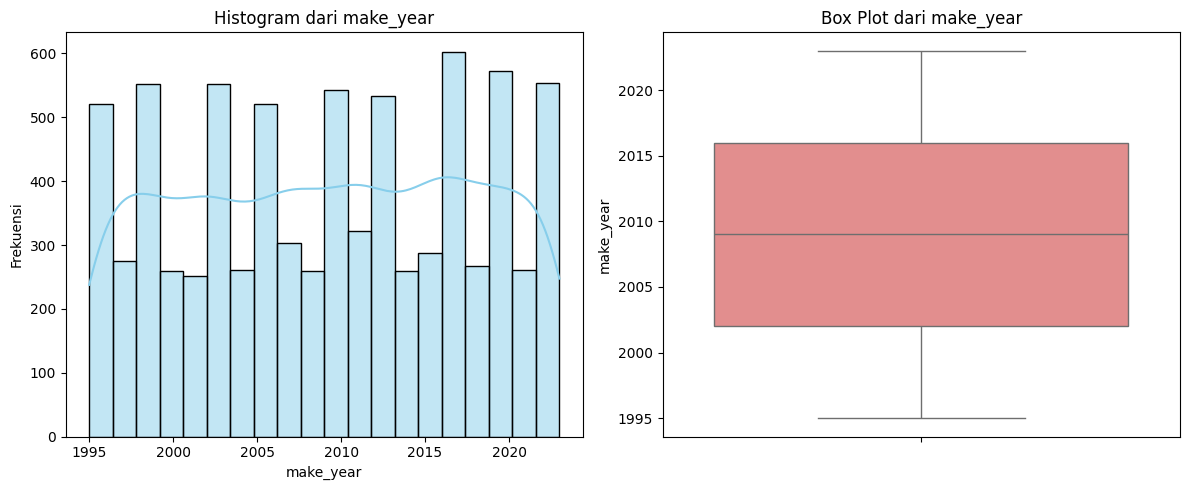

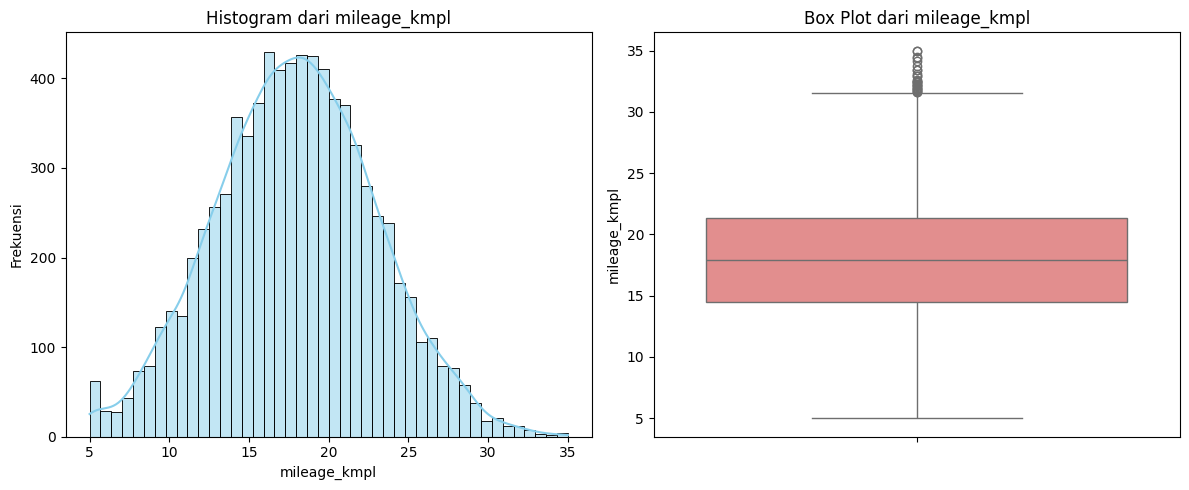

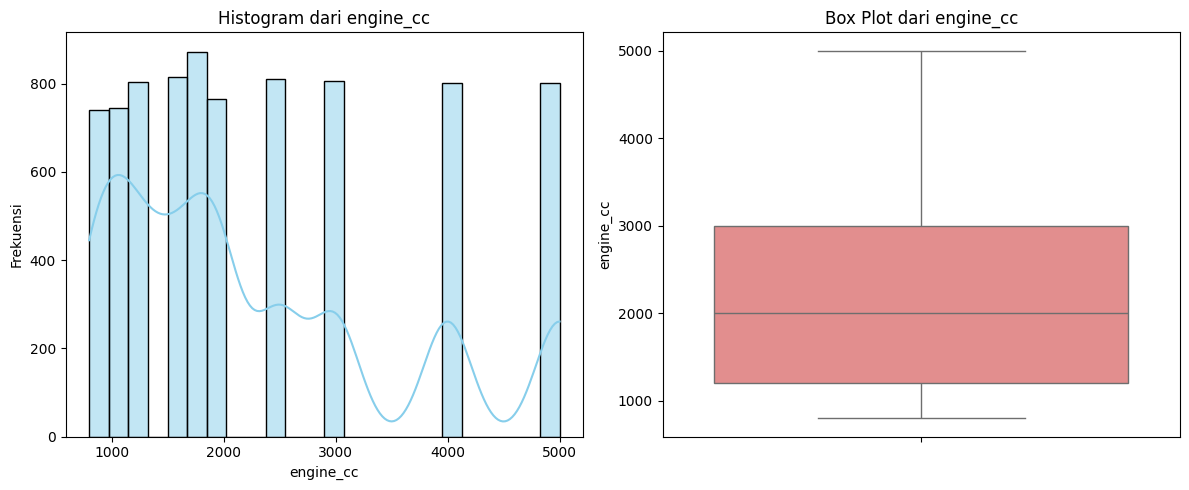

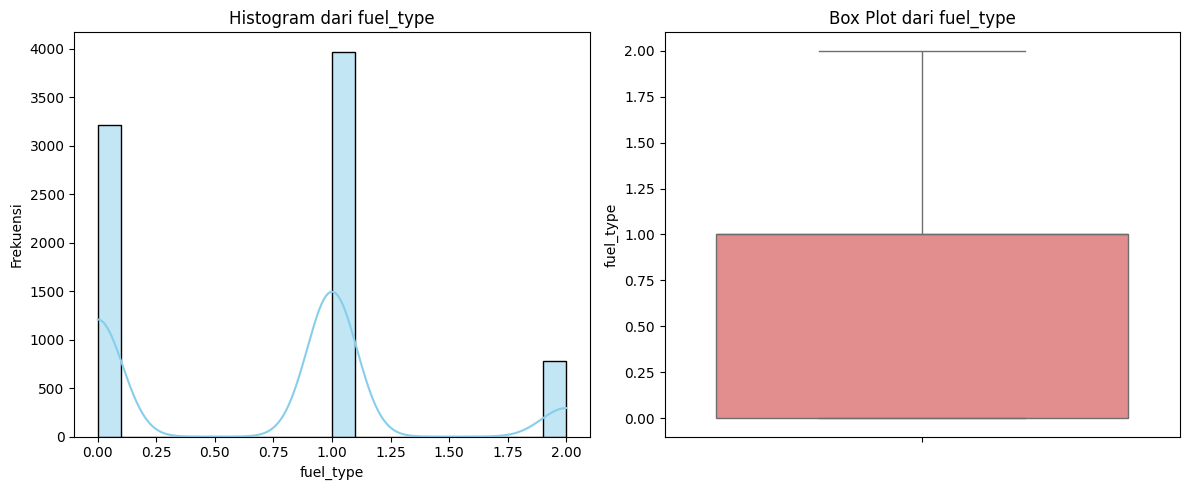

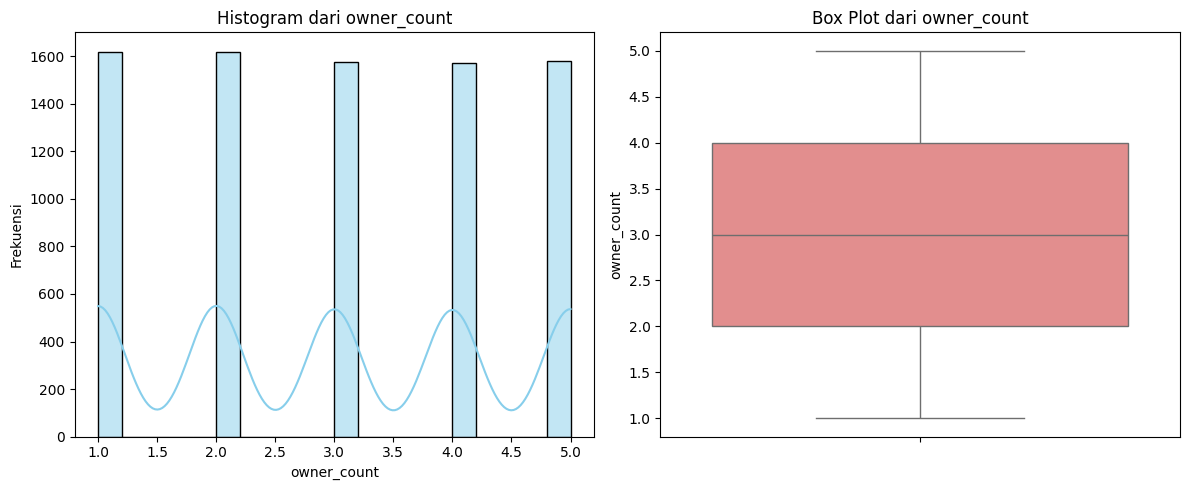

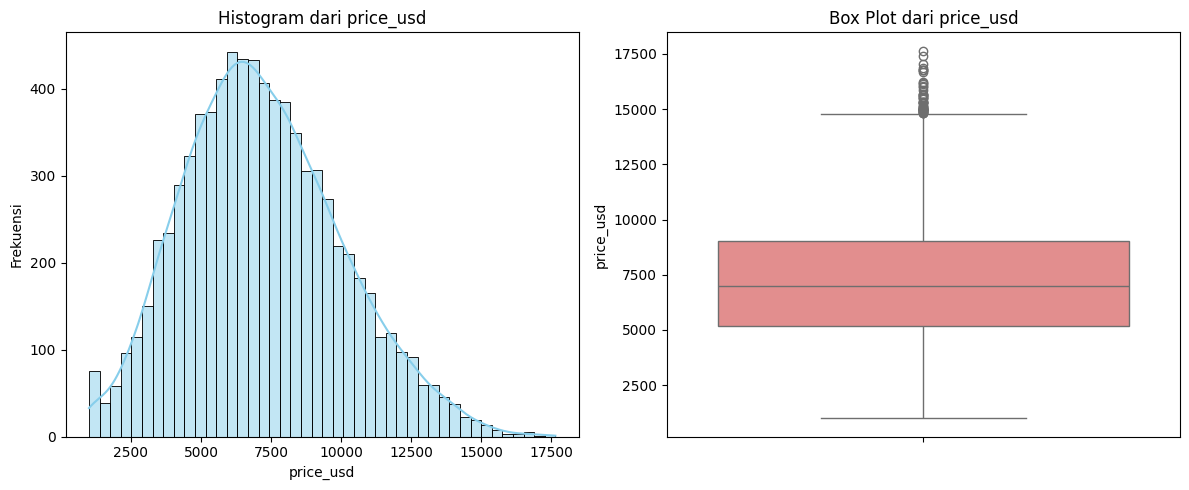

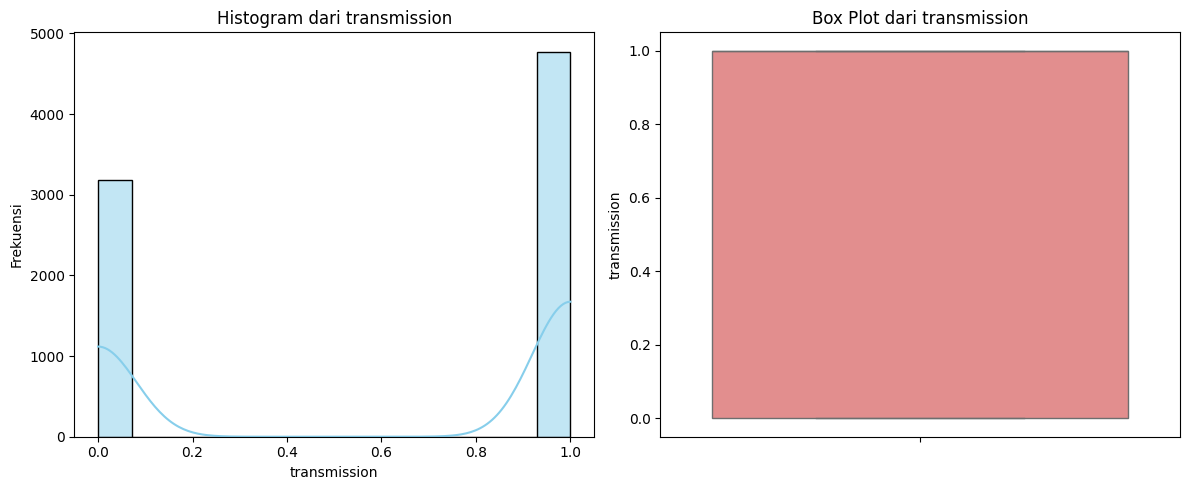

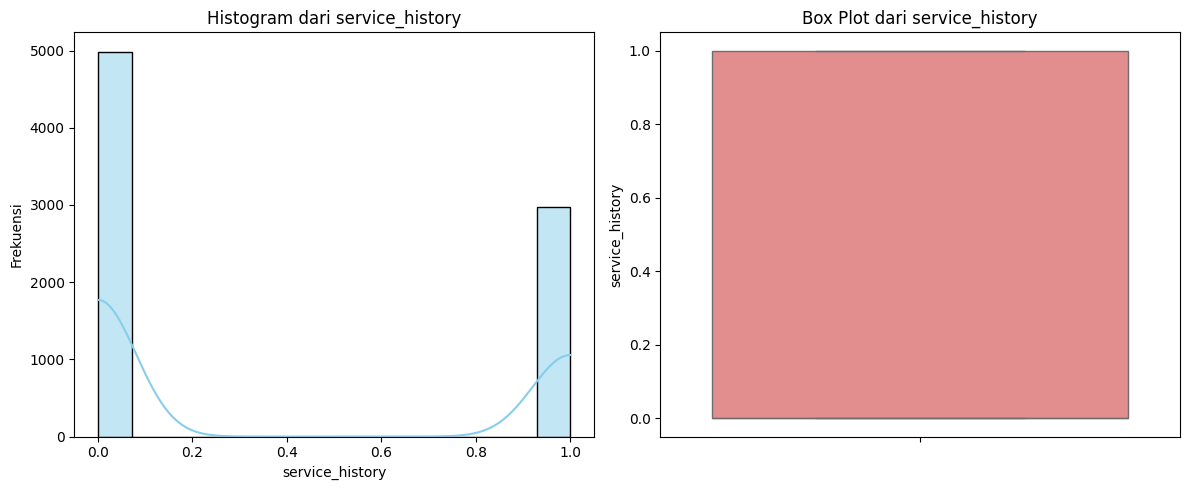

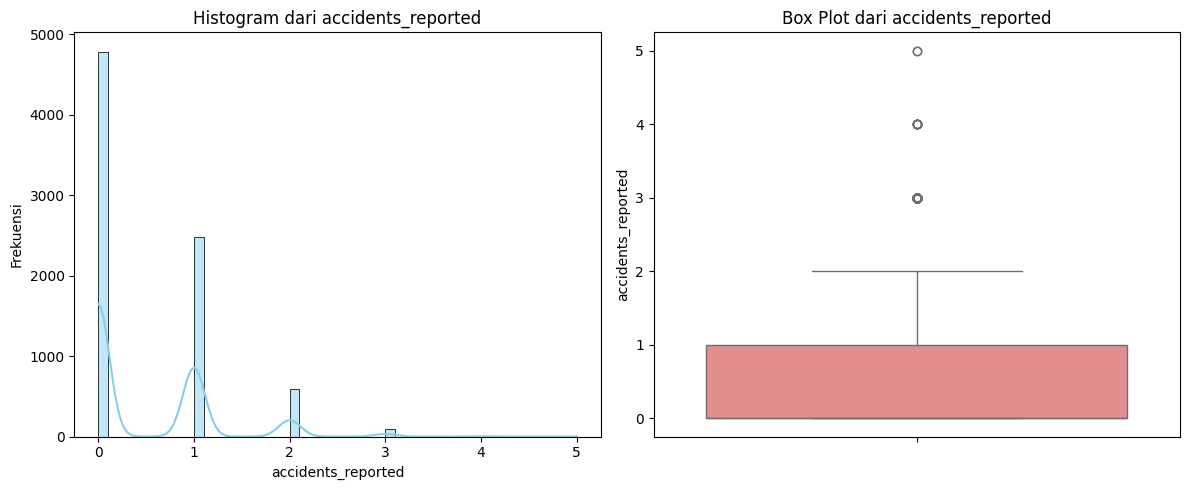

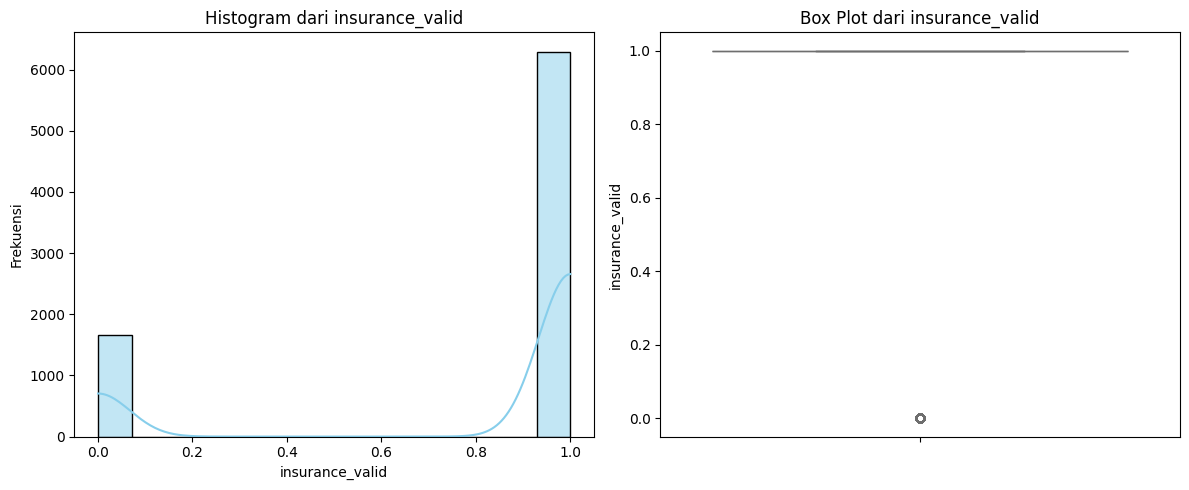

Tidak ada kolom kategorik dalam DataFrame ini.


In [18]:
visualisasiData(data)

In [19]:
fixed_features = ['make_year','mileage_kmpl','engine_cc','owner_count','transmission','service_history','accidents_reported','insurance_valid']
eksplorasiBestFitur(fixed_features, target, df, case=1)

Menguji kombinasi fitur tambahan: 100%|██████████| 1/1 [00:13<00:00, 13.14s/it]


,features,score,best_model
0,"[make_year, mileage_kmpl, engine_cc, owner_cou...",1037.4553,CatBoost


## Optimasi Klasifikasi berdasarkan Beberapa Model Regresi

In [ ]:
# Seed untuk reproducibility
np.random.seed(42)

# Buat 300 sampel, masing-masing indeks punya 5 fitur
n_samples = 300
X_A = np.random.rand(n_samples, 5)
X_B = np.random.rand(n_samples, 5)
X_C = np.random.rand(n_samples, 5)

# Simulasi nilai indeks A, B, C dengan noise dan skala 0-5
y_A = X_A.mean(axis=1) * 5 + np.random.normal(0, 0.3, n_samples)
y_B = X_B.mean(axis=1) * 5 + np.random.normal(0, 0.3, n_samples)
y_C = X_C.mean(axis=1) * 5 + np.random.normal(0, 0.3, n_samples)

# Clipping agar tetap dalam range 0–5
y_A = np.clip(y_A, 0, 5)
y_B = np.clip(y_B, 0, 5)
y_C = np.clip(y_C, 0, 5)

# Split train/val
X_A_train, X_A_val, yA_train, yA_val = train_test_split(X_A, y_A, test_size=0.2, random_state=42)
X_B_train, X_B_val, yB_train, yB_val = train_test_split(X_B, y_B, test_size=0.2, random_state=42)
X_C_train, X_C_val, yC_train, yC_val = train_test_split(X_C, y_C, test_size=0.2, random_state=42)

hasil = optimasiIndeksGabungan(
    X_A_train, X_A_val, yA_train, yA_val,
    X_B_train, X_B_val, yB_train, yB_val,
    X_C_train, X_C_val, yC_train, yC_val,
    n_trials=10
)

from pprint import pprint

print("Model Indeks A:", hasil["model_A"])
print("Param Model Indeks A:", hasil["params_A"])
print("Importance Model Indeks A:")
pprint(hasil["importance_A"])

print("\nModel Indeks B:", hasil["model_B"])
print("Param Model Indeks B:", hasil["params_B"])
print("Importance Model Indeks B:")
pprint(hasil["importance_B"])

print("\nModel Indeks C:", hasil["model_C"])
print("Param Model Indeks C:", hasil["params_C"])
print("Importance Model Indeks C:")
pprint(hasil["importance_C"])

print("\nF1 Macro:", hasil["f1_macro"])
print("Balanced Accuracy:", hasil["balanced_accuracy"])
print("ROC AUC Macro:", hasil["roc_auc_macro"])
print("\nConfusion Matrix:")
print(hasil["confusion_matrix"])
print("\nClassification Report:")
pprint(hasil["classification_report"])


[I 2025-06-22 17:53:57,113] A new study created in memory with name: no-name-ff53348e-0476-4e5d-9ceb-3aa9493e4125
[I 2025-06-22 17:54:01,256] Trial 0 finished with value: 0.4386292834890966 and parameters: {'model_A': 'catboost', 'model_B': 'catboost', 'model_C': 'catboost', 'iterations': 386, 'depth': 5, 'learning_rate': 0.08202446290608188, 'l2_leaf_reg': 9.036606455440532}. Best is trial 0 with value: 0.4386292834890966.
[I 2025-06-22 17:54:01,877] Trial 1 finished with value: 0.30303030303030304 and parameters: {'model_A': 'knn', 'model_B': 'catboost', 'model_C': 'knn', 'n_neighbors': 14, 'weights': 'distance', 'p': 2, 'iterations': 194, 'depth': 5, 'learning_rate': 0.14963531440917754, 'l2_leaf_reg': 1.7025495462486337}. Best is trial 0 with value: 0.4386292834890966.
[I 2025-06-22 17:54:03,005] Trial 2 finished with value: 0.38914373088685017 and parameters: {'model_A': 'rf', 'model_B': 'knn', 'model_C': 'rf', 'n_estimators': 241, 'max_depth': 16, 'min_samples_split': 7, 'min_sam

Model A: knn
Param A: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}
Importance A:
None

Model B: catboost
Param B: {'iterations': 285, 'depth': 5, 'learning_rate': 0.29653717025585646, 'l2_leaf_reg': 2.9843443257361444, 'verbose': 0}
Importance B:
{'B0': 19.625253769780826,
 'B1': 19.252158008930813,
 'B2': 20.139354372459916,
 'B3': 18.484512640132888,
 'B4': 22.498721208695564}

Model C: rf
Param C: {'n_estimators': 289, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4}
Importance C:
{'C0': 0.11179524343086045,
 'C1': 0.3118390710871113,
 'C2': 0.21045131468902697,
 'C3': 0.1842814039810344,
 'C4': 0.18163296681196692}

F1 Macro: 0.6595959595959596
Balanced Accuracy: 0.5806349206349206
ROC AUC Macro: 0.6871728062294099

Confusion Matrix:
[[ 3  4  0]
 [ 1 49  0]
 [ 0  2  1]]

Classification Report:
{'1': {'f1-score': 0.5454545454545454,
       'precision': 0.75,
       'recall': 0.42857142857142855,
       'support': 7.0},
 '2': {'f1-score': 0.9333333333333333,
      